# Race and Median Income

This is a deeper local analysis of some of the data from an [NJISJ report](https://njisj.org/reports/stateofinequity/) on Essex County
as reported in an [NJ Patch](https://patch.com/new-jersey/maplewood/s/iv2ag/essex-county-has-some-of-worst-racial-wealth-gaps-in-new-jersey-study?utm_source=local-update&utm_medium=email&utm_campaign=alert) article.

## Imports, Definitions, and Setup

In [1]:
from typing import List, Iterable

import censusdis.data as ced

from censusdis.datasets import ACS5

from censusdis.states import NJ
from censusdis.counties.new_jersey import (
    ESSEX,
    MONMOUTH,
    PASSAIC,
    MERCER,
    HUDSON,
    UNION,
    SOMERSET,
    MORRIS,
)

import pandas as pd
from matplotlib.ticker import FuncFormatter, PercentFormatter

In [2]:
MHI_WHITE = "B19013A_001E"
MHI_BLACK = "B19013B_001E"
MHI_HISPANIC_LATINO = "B19013I_001E"

VARIABLES = {
    MHI_WHITE: "White",
    MHI_BLACK: "Black",
    MHI_HISPANIC_LATINO: "Latina/o",
}

In [3]:
def data_for(**kwargs) -> pd.DataFrame:
    df = ced.download(
        dataset=ACS5,
        vintage=2022,
        download_variables=["NAME"] + list(VARIABLES.keys()),
        **kwargs,
    )

    df.rename(VARIABLES, axis="columns", inplace=True)

    return df


def add_diffs(df: pd.DataFrame) -> pd.DataFrame:
    for var, name in VARIABLES.items():
        if var != MHI_WHITE:
            df[f"{name} White Gap"] = df[VARIABLES[MHI_WHITE]] - df[name]
    return df

## Fetch County-Level Data

In [4]:
df_county = data_for(state=NJ, county="*")

In [5]:
add_diffs(df_county)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
0,34,001,"Atlantic County, New Jersey",83877,49658,50186,34219,33691
1,34,003,"Bergen County, New Jersey",120955,88587,90934,32368,30021
2,34,005,"Burlington County, New Jersey",105582,86391,85321,19191,20261
3,34,007,"Camden County, New Jersey",97286,55821,53993,41465,43293
4,34,009,"Cape May County, New Jersey",86368,41014,69381,45354,16987
5,34,011,"Cumberland County, New Jersey",72371,41250,51968,31121,20403
6,34,013,"Essex County, New Jersey",111609,54727,60235,56882,51374
7,34,015,"Gloucester County, New Jersey",103473,71010,82855,32463,20618
8,34,017,"Hudson County, New Jersey",97391,63023,63420,34368,33971
9,34,019,"Hunterdon County, New Jersey",132637,118125,122371,14512,10266


## Repro Figures 4 and 5

In [6]:
def white_vs(df: pd.DataFrame, counties: List[str], vs: str):
    df = pd.DataFrame(df[["COUNTY", "NAME", f"{VARIABLES[vs]} White Gap"]])

    df = df[df["COUNTY"].isin(counties)]

    county_order = {county: ii for ii, county in enumerate(counties)}

    df["ii"] = df["COUNTY"].apply(lambda c: county_order.get(c, -1))

    df.sort_values(by="ii", inplace=True)

    df.drop("ii", axis="columns", inplace=True)

    return df

In [7]:
white_vs(df_county, [ESSEX, MONMOUTH, PASSAIC, MERCER, HUDSON], MHI_BLACK)

,COUNTY,NAME,Black White Gap
6,013,"Essex County, New Jersey",56882
12,025,"Monmouth County, New Jersey",58447
15,031,"Passaic County, New Jersey",50521
10,021,"Mercer County, New Jersey",46653
8,017,"Hudson County, New Jersey",34368


In [8]:
white_vs(df_county, [ESSEX, UNION, HUDSON, SOMERSET, MORRIS], MHI_HISPANIC_LATINO)

,COUNTY,NAME,Latina/o White Gap
6,013,"Essex County, New Jersey",51374
19,039,"Union County, New Jersey",46899
8,017,"Hudson County, New Jersey",33971
17,035,"Somerset County, New Jersey",43813
13,027,"Morris County, New Jersey",41591


In [9]:
def plot_white_vs(df: pd.DataFrame, counties: Iterable[str], vs: str, title: str):

    counties = list(counties)

    gap_col = f"{VARIABLES[vs]} {VARIABLES[MHI_WHITE]} Gap"

    df_county_plot = pd.DataFrame(
        df[["COUNTY", VARIABLES[MHI_WHITE], VARIABLES[vs], gap_col]]
    )
    df_county_plot.index = df["NAME"].map(lambda name: name.split(",")[0])

    df_county_plot = df_county_plot[df_county_plot["COUNTY"].isin(counties)]

    county_order = {county: ii for ii, county in enumerate(counties)}

    df_county_plot["ii"] = df_county_plot["COUNTY"].apply(
        lambda c: county_order.get(c, -1)
    )

    df_county_plot.sort_values(by="ii", inplace=True)

    df_county_plot.drop("ii", axis="columns", inplace=True)

    print(df_county_plot.columns)

    ax = df_county_plot[["COUNTY", VARIABLES[MHI_WHITE], VARIABLES[vs]]].plot.bar(
        figsize=(10, 6)
    )

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"${x:,.0f}"))
    ax.yaxis.grid()

    ax.set_ylim(0, 140_000)

    ax.set_xticklabels(
        [
            f"{c}\n(${df_county_plot.loc[c][gap_col]:,.0f})"
            for c in df_county_plot.index
        ],
        rotation=45,
    )

    ax.set_ylabel("Median Household Income")
    ax.set_xlabel("County\n(Income Gap)")
    ax.set_title(title)

    return ax

Index(['COUNTY', 'White', 'Black', 'Black White Gap'], dtype='object')


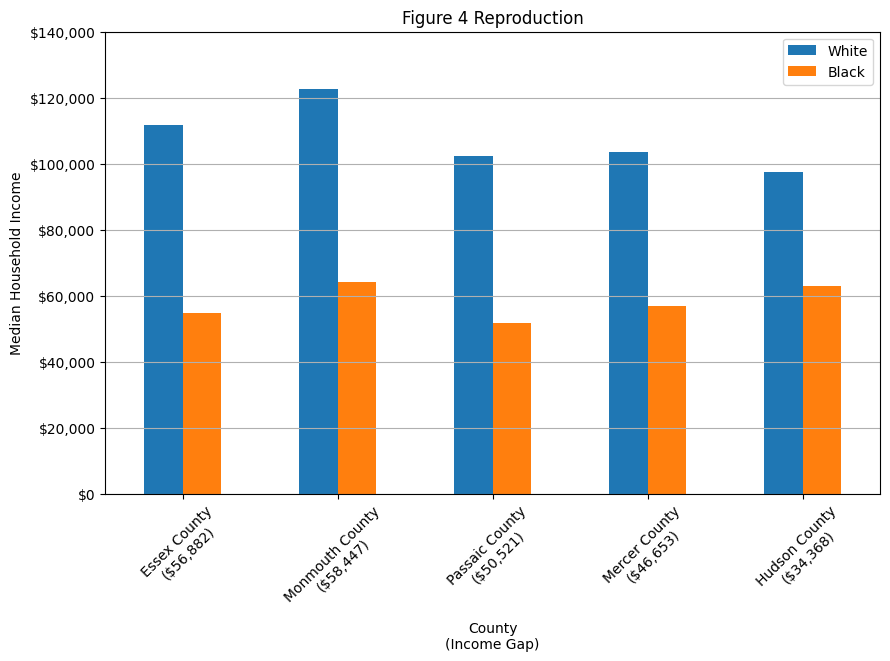

In [10]:
ax = plot_white_vs(
    df_county,
    [ESSEX, MONMOUTH, PASSAIC, MERCER, HUDSON],
    MHI_BLACK,
    "Figure 4 Reproduction",
)

Index(['COUNTY', 'White', 'Latina/o', 'Latina/o White Gap'], dtype='object')


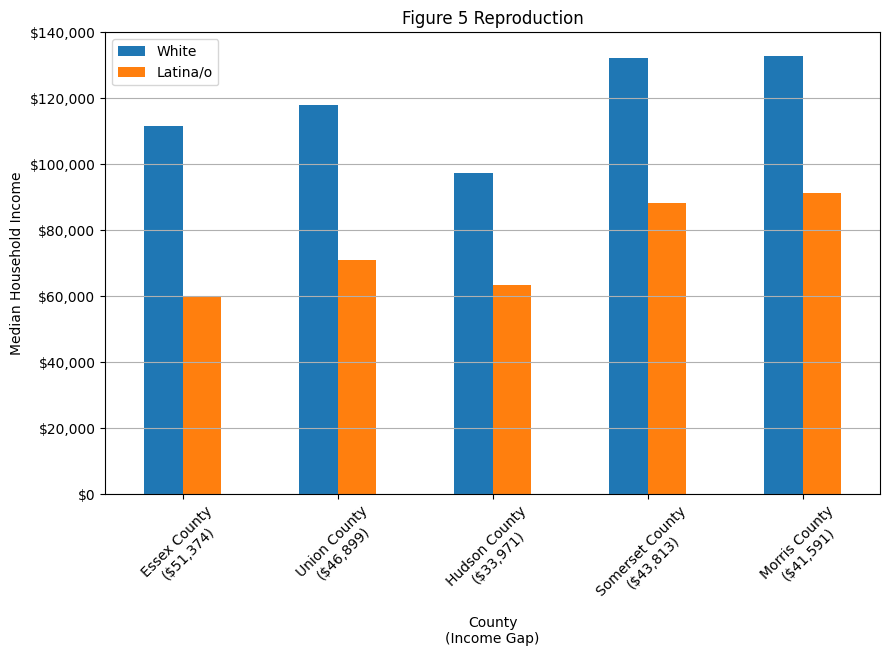

In [11]:
ax = plot_white_vs(
    df_county,
    [ESSEX, UNION, HUDSON, SOMERSET, MORRIS],
    MHI_HISPANIC_LATINO,
    "Figure 5 Reproduction",
)

## Are the Top Five Right?

In [12]:
def order_by_gap(df: pd.DataFrame, vs: str) -> pd.DataFrame:
    df = df.sort_values(by=f"{VARIABLES[vs]} White Gap", ascending=False)

    return df

In [13]:
df_top_black_gap = order_by_gap(df_county, MHI_BLACK).head(5)
df_top_black_gap

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
12,34,025,"Monmouth County, New Jersey",122450,64003,90889,58447,31561
6,34,013,"Essex County, New Jersey",111609,54727,60235,56882,51374
15,34,031,"Passaic County, New Jersey",102264,51743,64167,50521,38097
10,34,021,"Mercer County, New Jersey",103481,56828,72250,46653,31231
4,34,009,"Cape May County, New Jersey",86368,41014,69381,45354,16987


In [14]:
df_top_hispanic_latino_gap = order_by_gap(df_county, MHI_HISPANIC_LATINO).head(5)
df_top_hispanic_latino_gap

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
6,34,013,"Essex County, New Jersey",111609,54727,60235,56882,51374
19,34,039,"Union County, New Jersey",118002,81578,71103,36424,46899
17,34,035,"Somerset County, New Jersey",132122,100730,88309,31392,43813
3,34,007,"Camden County, New Jersey",97286,55821,53993,41465,43293
13,34,027,"Morris County, New Jersey",132759,89511,91168,43248,41591


## Bottom 5

The bottoms appear in figures 6 and 7 of the NJISJ report.

In [15]:
order_by_gap(df_county, MHI_BLACK).tail(5)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
14,34,029,"Ocean County, New Jersey",82649,64306,80660,18343,1989
9,34,019,"Hunterdon County, New Jersey",132637,118125,122371,14512,10266
11,34,023,"Middlesex County, New Jersey",97855,90049,77774,7806,20081
20,34,041,"Warren County, New Jersey",93750,91692,82612,2058,11138
18,34,037,"Sussex County, New Jersey",110152,134810,101243,-24658,8909


In [16]:
order_by_gap(df_county, MHI_HISPANIC_LATINO).tail(5)

,STATE,COUNTY,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
4,34,009,"Cape May County, New Jersey",86368,41014,69381,45354,16987
20,34,041,"Warren County, New Jersey",93750,91692,82612,2058,11138
9,34,019,"Hunterdon County, New Jersey",132637,118125,122371,14512,10266
18,34,037,"Sussex County, New Jersey",110152,134810,101243,-24658,8909
14,34,029,"Ocean County, New Jersey",82649,64306,80660,18343,1989


## Top 5 Plots

Index(['COUNTY', 'White', 'Black', 'Black White Gap'], dtype='object')


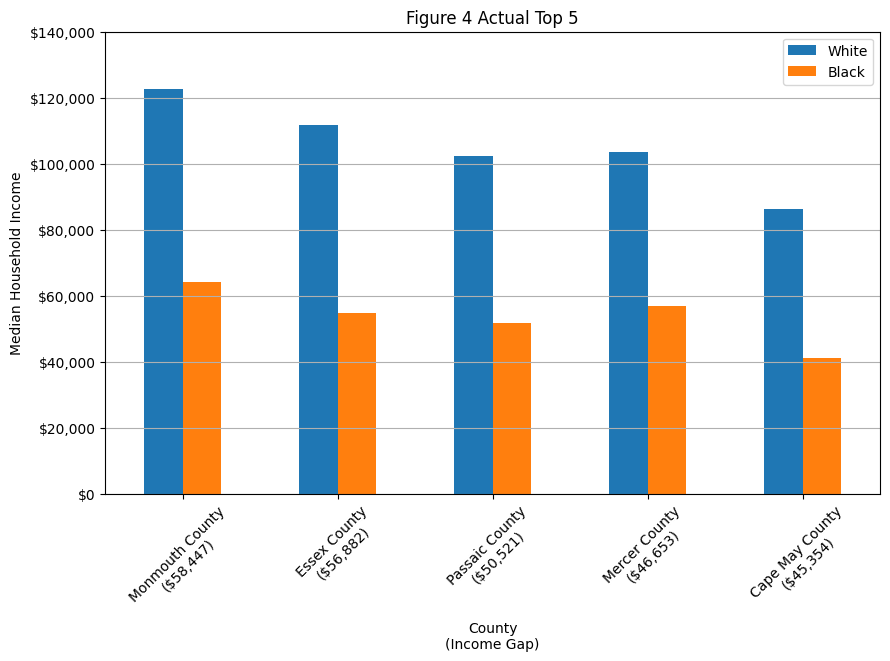

In [17]:
ax = plot_white_vs(
    df_top_black_gap, df_top_black_gap["COUNTY"], MHI_BLACK, "Figure 4 Actual Top 5"
)

Index(['COUNTY', 'White', 'Latina/o', 'Latina/o White Gap'], dtype='object')


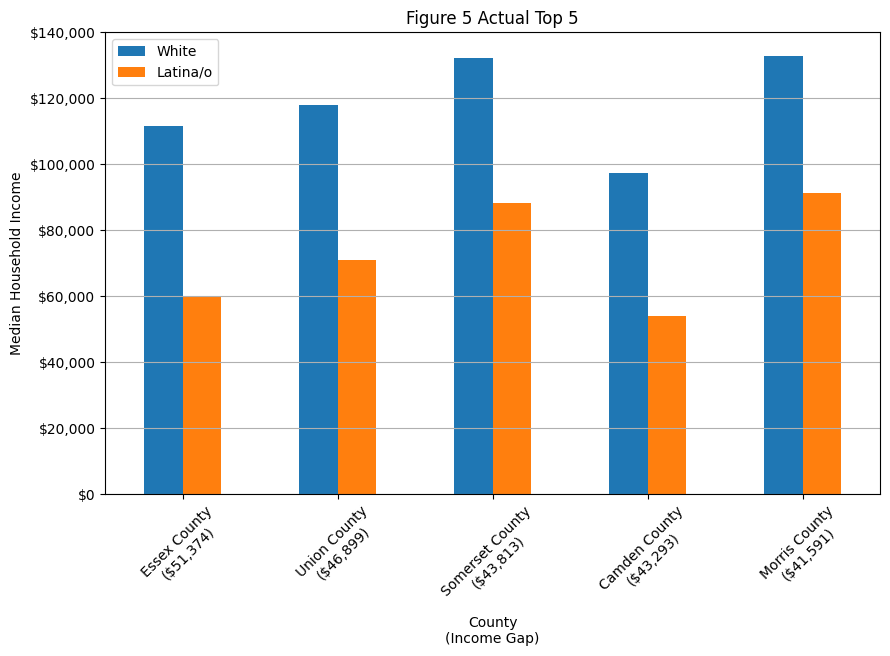

In [18]:
ax = plot_white_vs(
    df_top_hispanic_latino_gap,
    df_top_hispanic_latino_gap["COUNTY"],
    MHI_HISPANIC_LATINO,
    "Figure 5 Actual Top 5",
)

## SoMa

In [19]:
df_soma = data_for(zip_code_tabulation_area=["07079", "07040"])
add_diffs(df_soma)

,ZIP_CODE_TABULATION_AREA,NAME,White,Black,Latina/o,Black White Gap,Latina/o White Gap
0,07040,ZCTA5 07040,228710,102930,137092,125780,91618
1,07079,ZCTA5 07079,185245,139292,160357,45953,24888
